In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Random Forest vs Linear Regression

In [2]:
# load  traffic, weather, and air quality index datasets
fremont = pd.read_csv('Fremont_Bridge_Bicycle_Counter.csv',index_col='Date',parse_dates=True).resample('d').sum()
weather = pd.read_csv('Seattle_weather.csv',index_col='DATE',parse_dates=True)
aqi = pd.read_csv('Seattle_air_quality_index.csv',index_col='Date',parse_dates=True)

# add day of the week/month/year/covid columns
fremont['day_of_week'] = fremont.index.dayofweek
fremont['month'] = fremont.index.month
fremont['year'] = fremont.index.year
fremont['covid'] = 0
fremont.loc['03-01-2020':,'covid'] = 1

# add holidays column
from pandas.tseries.holiday import USFederalHolidayCalendar
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays('01-01-2013','09-30-2022')
fremont['holidays'] = pd.Series(1,index=holidays,name='holidays')
fremont.fillna(0,inplace=True)

# add hours of daylight column
def get_hoursdaylight(date):
    axis = np.radians(23.44) # tilt of Earth's axis
    latitude = np.radians(47.61) # Seattle's latidude 
    days = (date-pd.to_datetime('2000-12-31')).days
    m = (1 - np.tan(latitude)*np.tan(axis*np.cos(days*2*np.pi/365.25)))
    return 24*np.degrees(np.arccos(1-m))/180
fremont['hours_daylight'] = fremont.index.map(get_hoursdaylight)

# fix TAVG column
weather.TAVG.fillna(0.5*(weather.TMAX+weather.TMIN),inplace=True)

# join weather and traffic datasets
fremont = fremont.join(weather[['PRCP','TAVG','SNOW','AWND']]).loc['2013-01-01':]

# add air quality index
fremont['aqi'] = aqi

# fix aqi missing values
fremont.fillna(method='ffill',inplace=True)

In [3]:
# 2013-2020
fremont2013_2020 = fremont[fremont.index.year<2021].copy()
# 2020-2022
fremont2021_2022 = fremont[fremont.index.year>=2021].copy()

# target vector / feature matrix
y2013_2020 = fremont2013_2020['Fremont Bridge Total']
X2013_2020 = fremont2013_2020[['day_of_week','covid','holidays','hours_daylight','PRCP','TAVG','SNOW','AWND','year','aqi']]

X2021_2022 = fremont2021_2022[['day_of_week','covid','holidays','hours_daylight','year','PRCP','TAVG','SNOW','AWND','aqi']]
y2021_2022 = fremont2021_2022['Fremont Bridge Total']

## Linear Regression

In [5]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PolynomialFeatures

In [7]:
num_features = ['hours_daylight','PRCP','TAVG','SNOW','AWND','year','aqi']
cat_features = ['day_of_week','covid','holidays']

In [8]:
feature_processor = ColumnTransformer(transformers=[
    ('encoder',OneHotEncoder(handle_unknown='ignore'),cat_features),
],remainder='passthrough')

# regression pipeline
pipe = Pipeline(steps=[
    ('feature_processor',feature_processor),
    ('scaler', MinMaxScaler()),
    ('poly_features',PolynomialFeatures(degree=2)),
    ('regressor',Ridge(alpha=1)) #  Rige, Lasso or LinearRegression
])

In [10]:
pipe.fit(X2013_2020,y2013_2020)
fremont2013_2020['predicted'] = pipe.predict(X2013_2020)

Text(0.5, 1.0, 'daily traffic, 2013-2020')

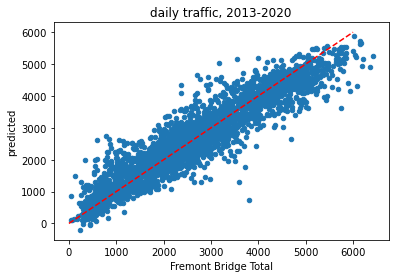

In [11]:
fremont2013_2020.plot.scatter(x='Fremont Bridge Total',y='predicted')
plt.plot([0,6000],[0,6000],'r--')
plt.title('daily traffic, 2013-2020')

## Random Forest

In [14]:
# random forest pipeline
from sklearn.ensemble import RandomForestRegressor
pipe = Pipeline(steps=[
    ('feature_processor',feature_processor),
    ('regressor',RandomForestRegressor())
])

In [15]:
# Grid Search
from sklearn.model_selection import GridSearchCV
param_dic = {'regressor__n_estimators' :[10,50,100,200,500],
             'regressor__max_depth':[2,5,10],
             'regressor__max_leaf_nodes' : [None,2,4,8],  # None = unlimited
             'regressor__min_samples_split' : [2,4,8,16,32], # default value = 2
             'regressor__min_samples_leaf' : [1,2,4,8,16,32] # default value = 1
            } 
grid = GridSearchCV(pipe, 
                    param_dic,
                    cv=5,
                    n_jobs=-1, 
                    scoring='neg_mean_squared_error',
                    verbose=True)

grid.fit(X2013_2020,y2013_2020)

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_processor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['day_of_week',
                                                                          'covid',
                                                                          'holidays'])])),
                                       ('regressor', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [2, 5, 10],
                         'regressor__max_leaf_nodes': [None, 2, 4, 8],
                         'regressor__min_samples_leaf': [1, 2, 4, 8, 16, 32],
                         'regressor__min_samples_split': [2, 4

In [16]:
# best random forest parameters
grid.best_params_

{'regressor__max_depth': 10,
 'regressor__max_leaf_nodes': None,
 'regressor__min_samples_leaf': 2,
 'regressor__min_samples_split': 2,
 'regressor__n_estimators': 100}

In [20]:
best_pipe = grid.best_estimator_
fremont2013_2020['predicted_rf'] = best_pipe.predict(X2013_2020)
fremont2021_2022['predicted_rf'] = best_pipe.predict(X2021_2022)

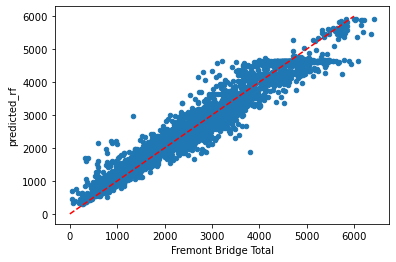

In [21]:
fremont2013_2020.plot.scatter(x='Fremont Bridge Total',y='predicted_rf')
plt.plot([0,6000],[0,6000],'r--')